In [1]:
!pip install seclea-ai==1.0.2
!conda install seclea-ai==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 KB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickleDB: filename=pickleDB-0.9.2-py3-none-any.whl size=4269 sha256=4225c3a513d3dfbd61db5325ec9a2504e7995f6155e574d03b3cf636631c4095
  Stored in directory: /root/.cache/pip/wheels/88/91/d4/ef2e6a46ad2bc41f9cfad35fa2db5b34357a5e4da67c385ffa
Successfully built pickleDB
/bin/bash: conda: command not found


In [2]:
from seclea_ai import SecleaAI

# NOTE - use the organization name provided to you when issued credentials.
seclea = SecleaAI(project_name="AirPollution", organization='Seclea')

Username: mariaantony
Password: ··········
success


In [13]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.11.0


In [14]:
air_pollution = pd.read_csv('/content/air_pollution.csv', parse_dates=['date'])
air_pollution.set_index('date', inplace=True)
air_pollution.head()

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
date,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333


*Loading the data*

In [15]:
# define the metadata for the dataset.
dataset_metadata = {"outcome_name": "pollution_today",
                    "continuous_features": [
                                            "dew",
                                            'temp',
                                            'press',
                                            'wnd_spd',
                                            'snow',
                                            'rain',
                                            'pollution_yesterday',
                                            ]}

In [6]:
# ⬆️ upload the dataset - pick a meaningful name here, you'll be seeing it a lot on the platform!
seclea.upload_dataset(dataset=air_pollution, dataset_name="Air Pollution", metadata=dataset_metadata)

In [16]:
air_pollution.describe()


,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,98.245080,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,98.245080
std,76.807697,14.163508,11.552997,10.076053,41.373161,0.546072,0.993917,76.807697
min,3.166667,-33.333333,-14.458333,994.041667,1.412500,0.000000,0.000000,3.166667
25%,42.333333,-10.083333,1.541667,1007.916667,5.904167,0.000000,0.000000,42.333333
50%,79.166667,2.041667,13.916667,1016.208333,10.953750,0.000000,0.000000,79.166667
75%,131.166667,15.083333,23.166667,1024.541667,22.235000,0.000000,0.000000,131.166667
max,541.895833,26.208333,32.875000,1043.458333,463.187917,14.166667,17.583333,541.895833


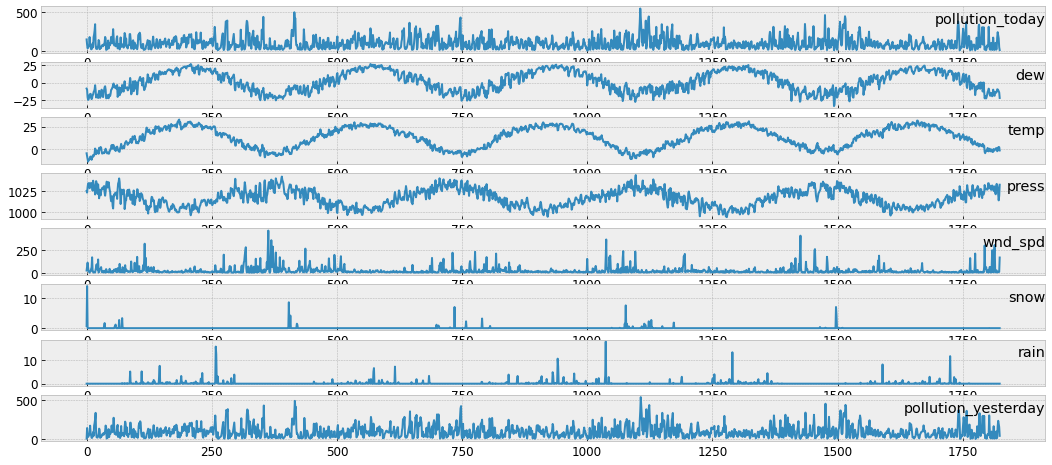

In [17]:
values = air_pollution.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(air_pollution.columns[group], y=0.5, loc='right')
    i += 1


plt.show()

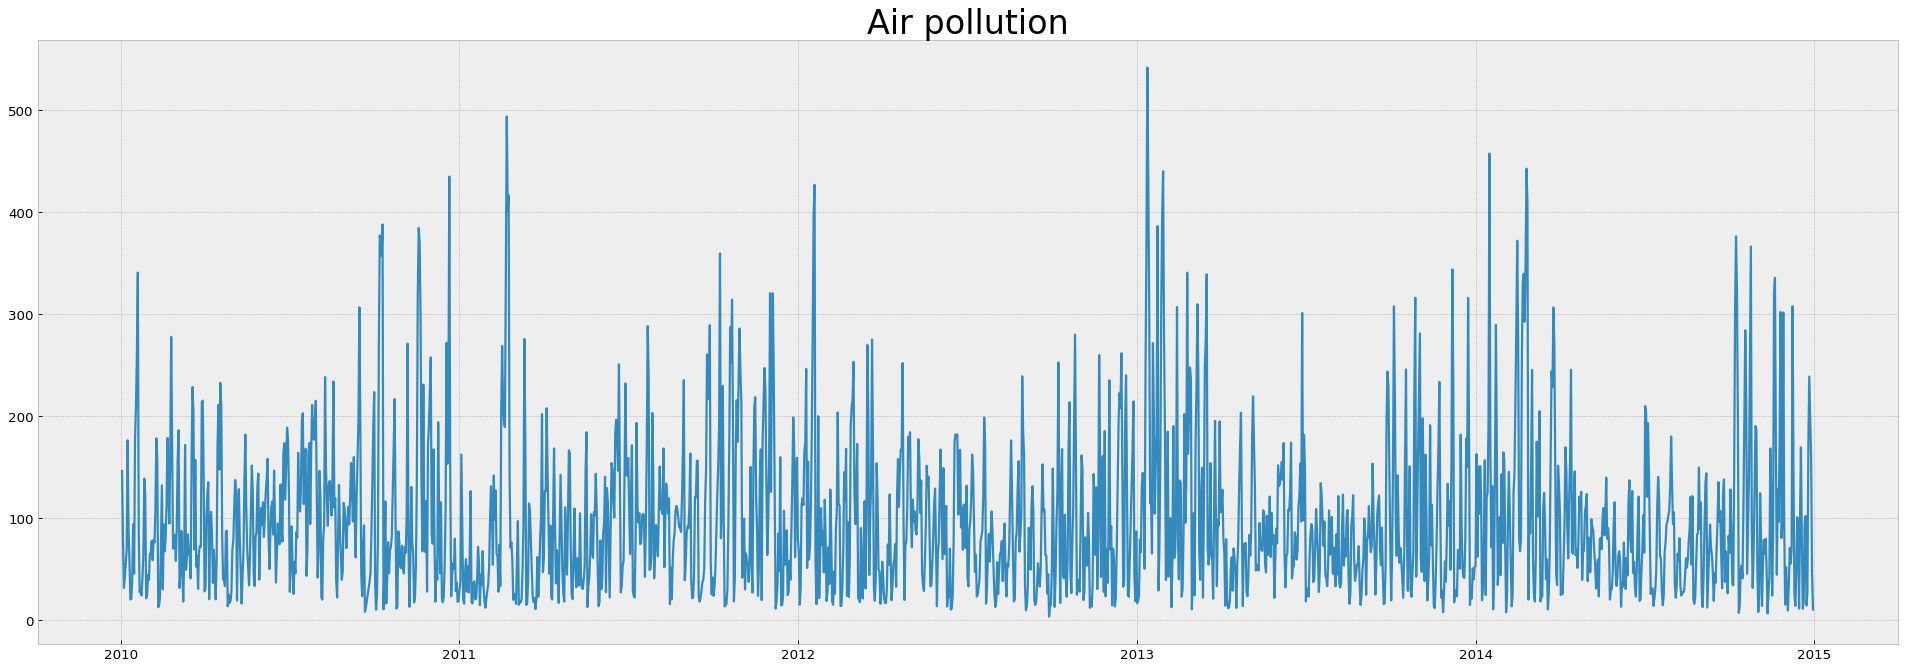

In [18]:
plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.title('Air pollution', fontsize=30)

plt.plot(air_pollution.pollution_today)

Decomposing time series

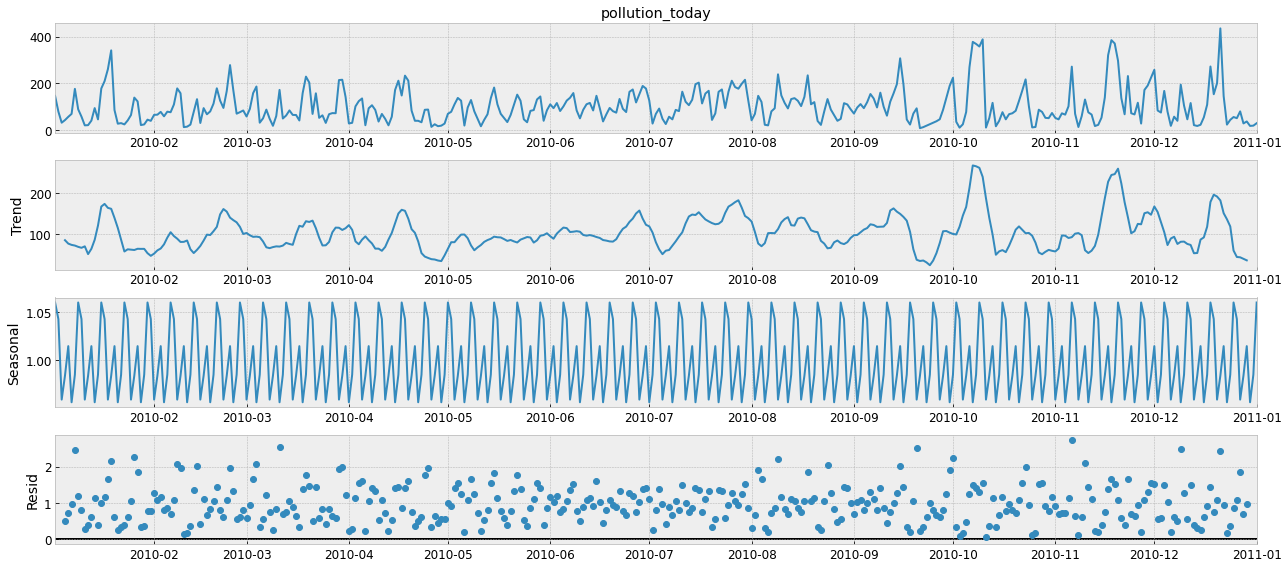

<Figure size 4000x1600 with 0 Axes>

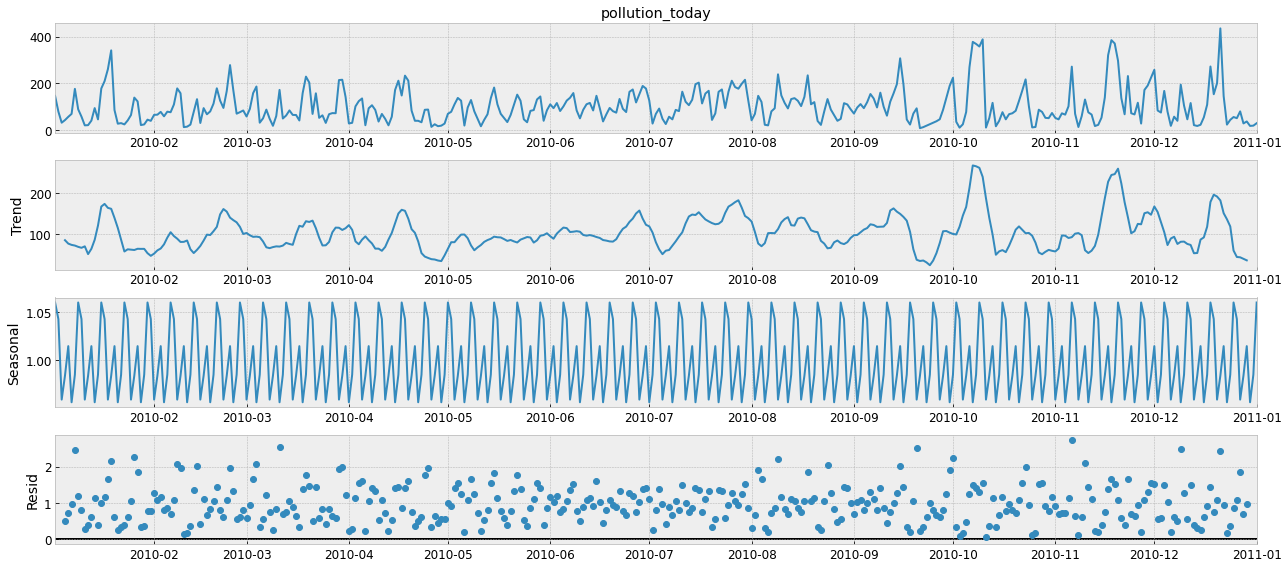

In [19]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

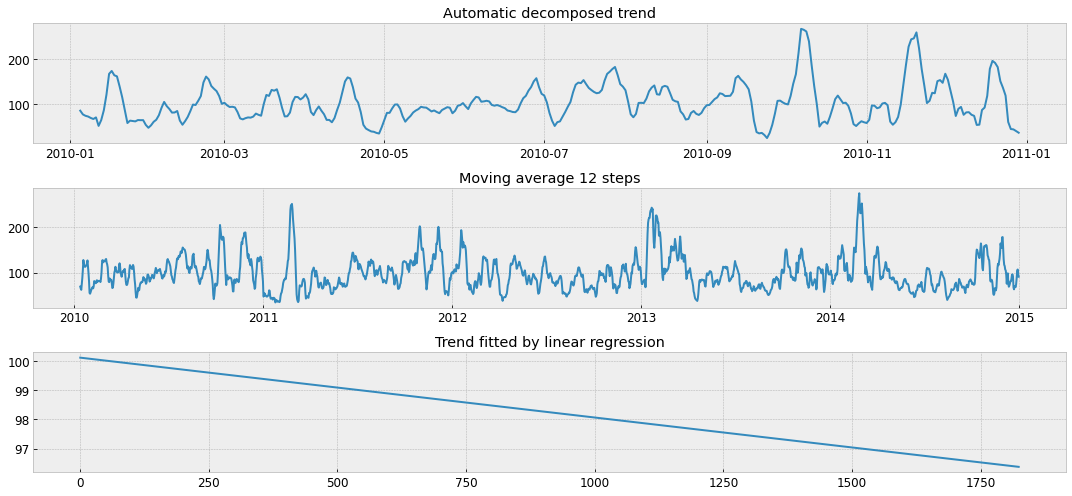

In [20]:
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(result.trend)
pm_ax.set_title("Automatic decomposed trend")

mm = air_pollution.pollution_today.rolling(12).mean()
mv_ax.plot(mm)
mv_ax.set_title("Moving average 12 steps")


X = [i for i in range(0, len(air_pollution.pollution_today))]
X = np.reshape(X, (len(X), 1))
y = air_pollution.pollution_today.values
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

Seasonality

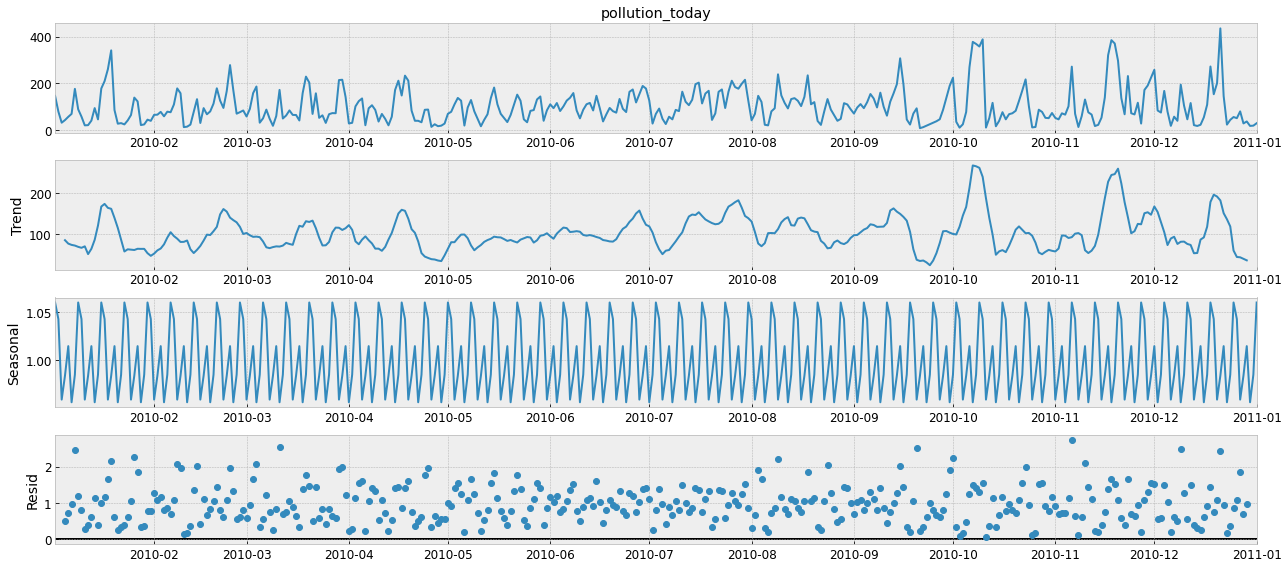

<Figure size 4000x1600 with 0 Axes>

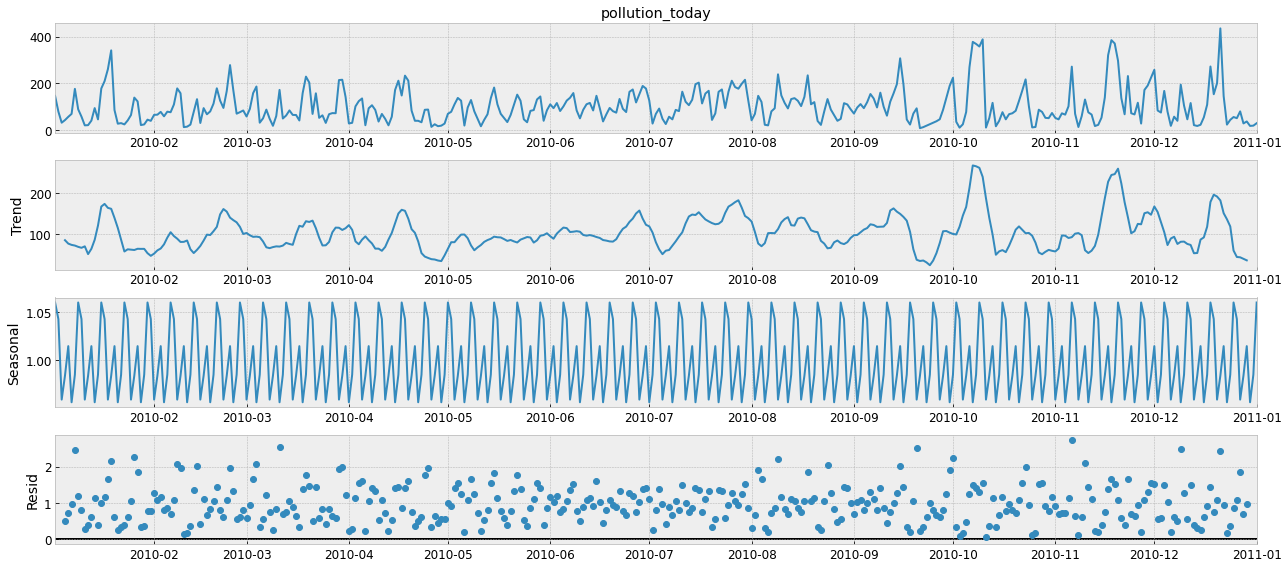

In [21]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[:365]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

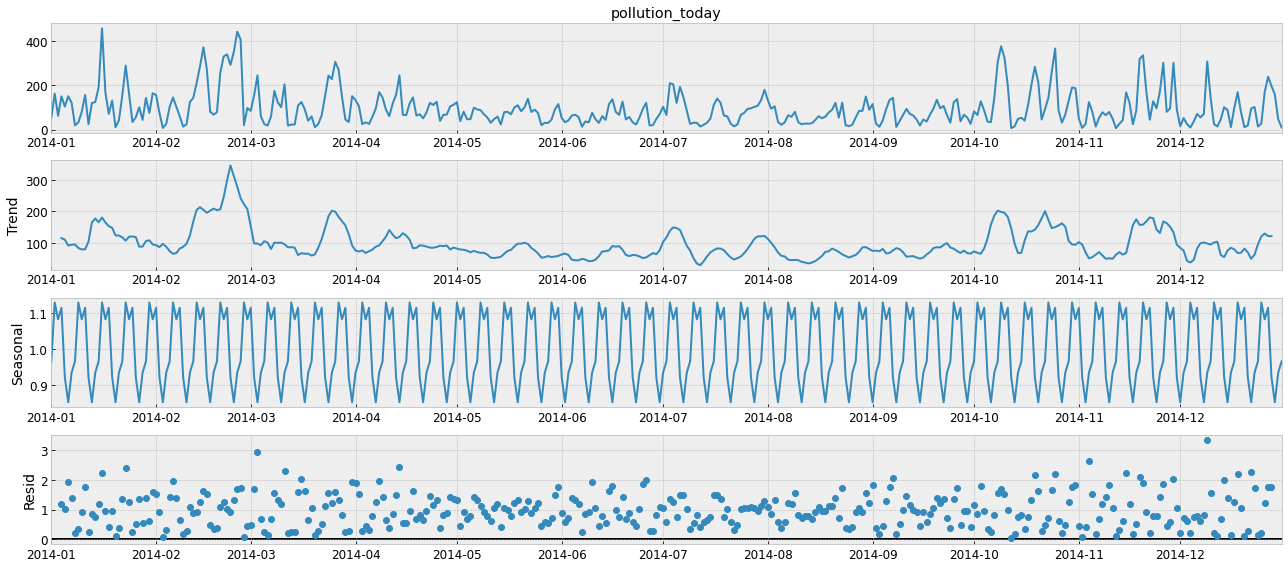

<Figure size 4000x1600 with 0 Axes>

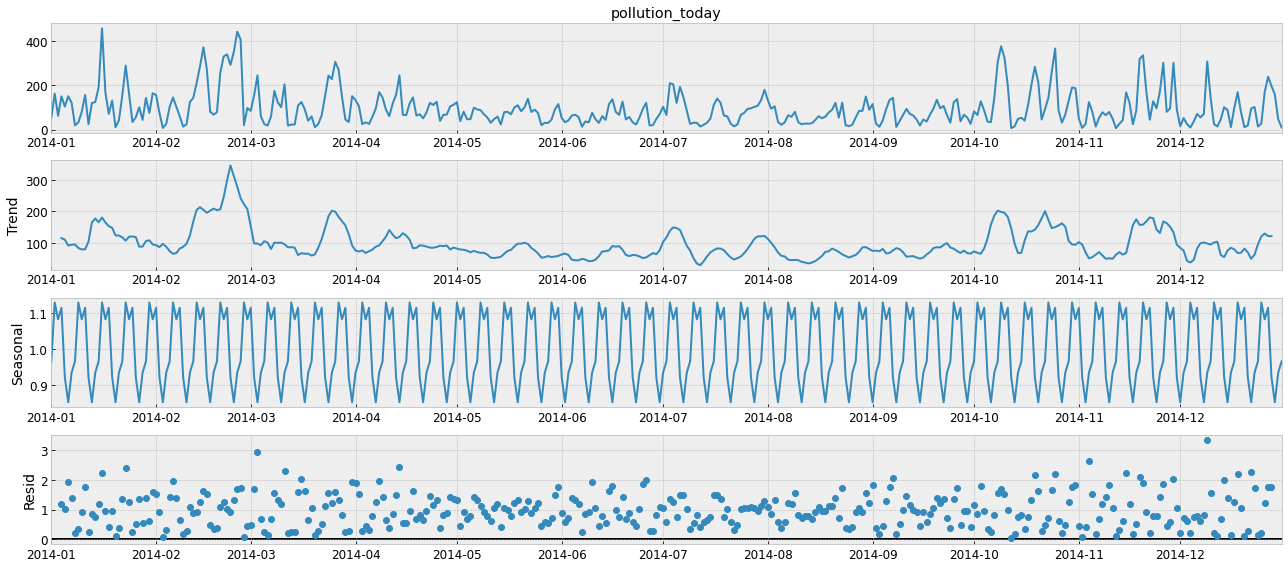

In [22]:
rcParams['figure.figsize'] = 18, 8
plt.figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
series = air_pollution.pollution_today[-365:]
result = seasonal_decompose(series, model='multiplicative')
result.plot()

INTERPRETATION


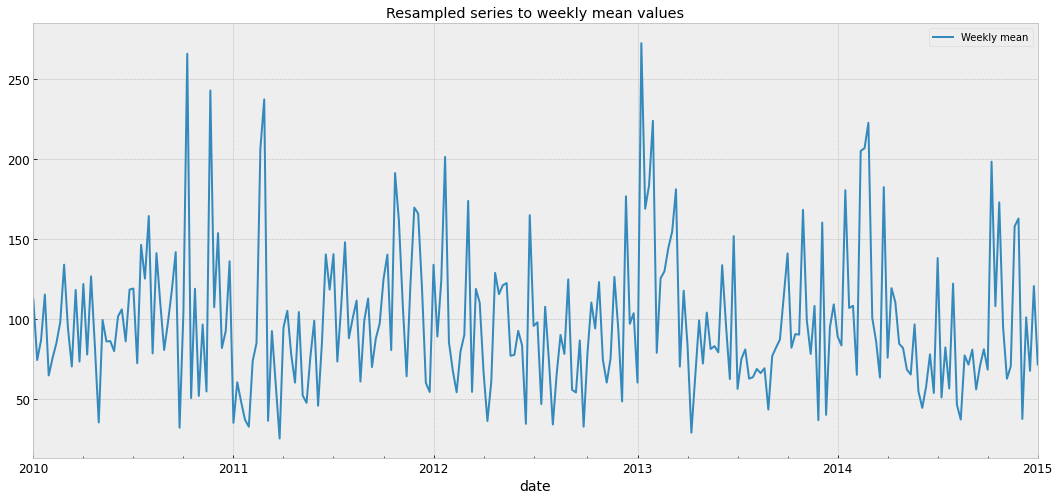

In [23]:
# Looking for weekly seasonality
resample = air_pollution.resample('W')
weekly_mean = resample.mean()
weekly_mean.pollution_today.plot(label='Weekly mean')
plt.title("Resampled series to weekly mean values")
plt.legend()

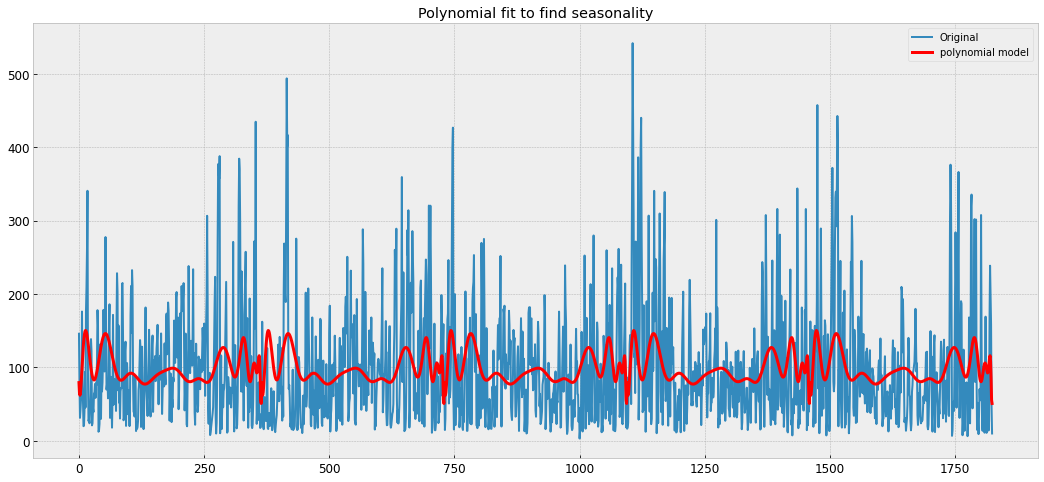

In [24]:
# Fix xticks to show dates
# fit polynomial: x^2*b1 + x*b2 + ... + bn
series = air_pollution.pollution_today.values
X = [i % 365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
# plot curve over original data
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model')
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

Text(0.5, 1.0, 'Mean over time')

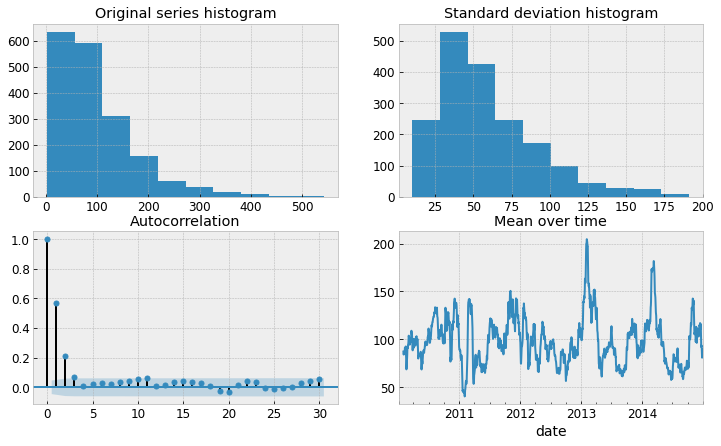

In [25]:
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

air_pollution.pollution_today.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = air_pollution.pollution_today.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = air_pollution.pollution_today.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

Stationarity
Autocorrelation and Partial autocorrelation plots



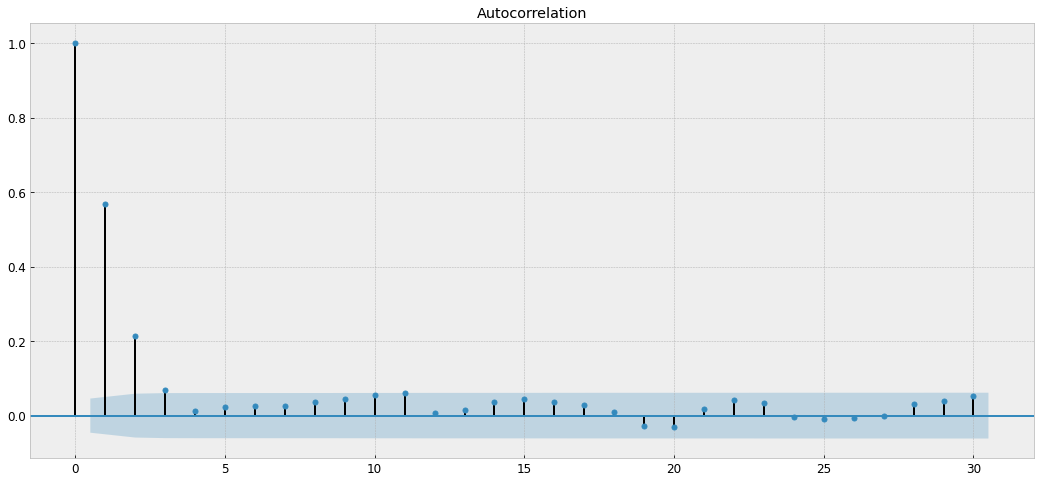

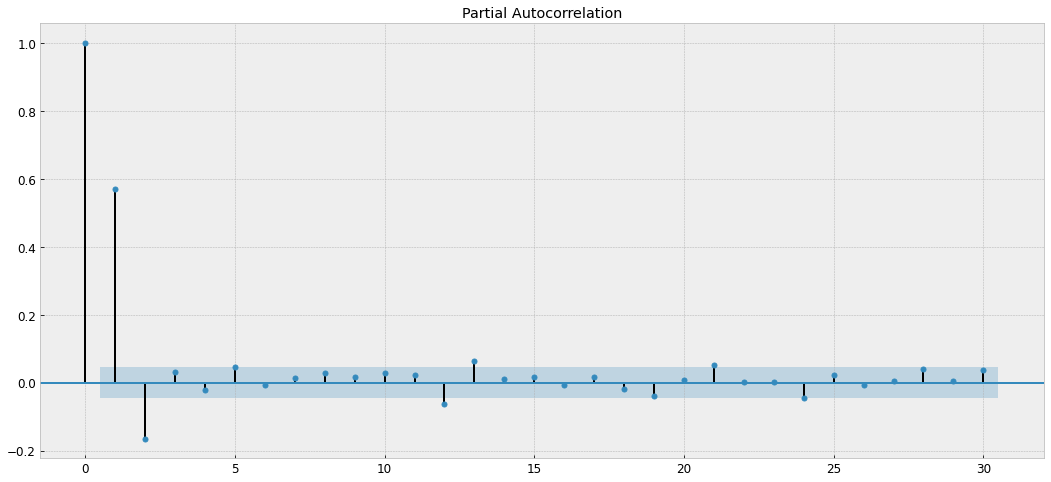

In [26]:
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()



```
Rolling means and standard deviation of our series
```



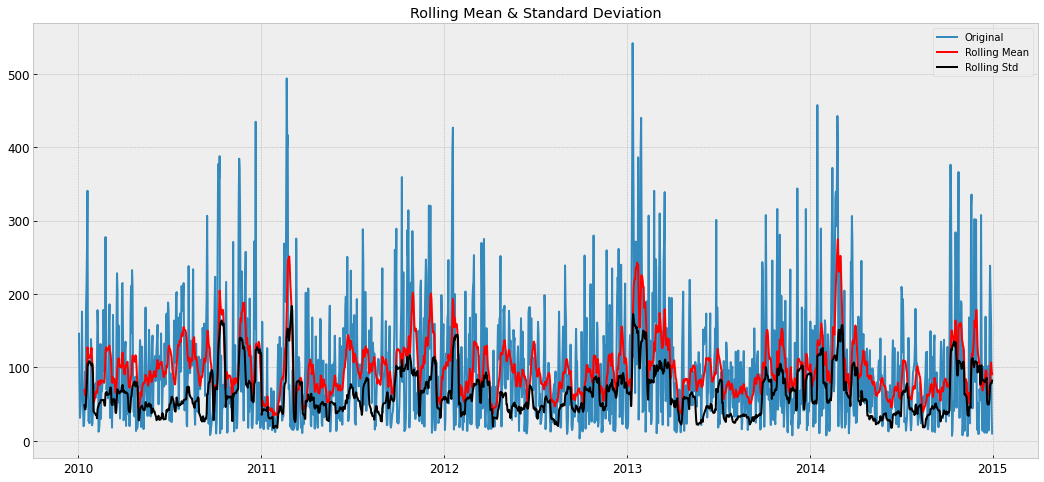

In [27]:
# Determing rolling statistics
rolmean = air_pollution.pollution_today.rolling(window=12).mean()
rolstd = air_pollution.pollution_today.rolling(window=12).std()

# Plot rolling statistics:
orig = plt.plot(air_pollution.pollution_today, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Augmented Dickey-Fuller test


In [28]:
X = air_pollution.pollution_today.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.116719
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


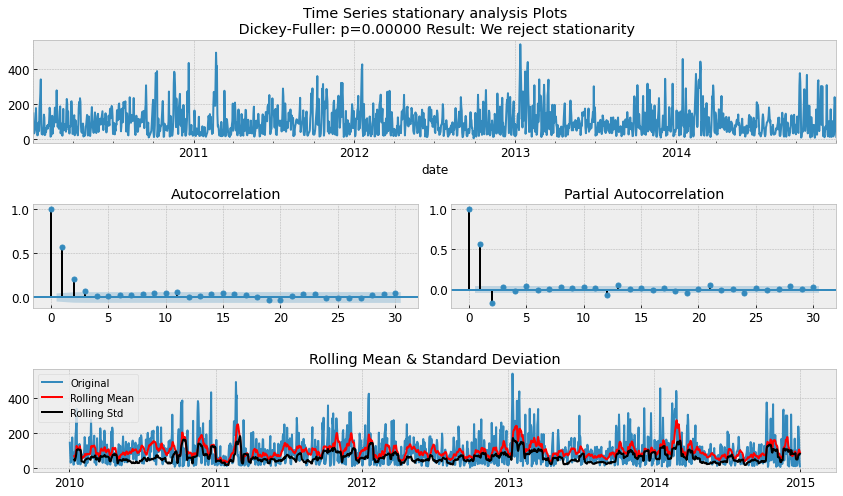

In [29]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "We reject stationarity" if p_value <= 0.05 else "We can not reject stationarity"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = air_pollution.pollution_today.rolling(window=12).mean()
        rolstd = air_pollution.pollution_today.rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(air_pollution.pollution_today, label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(air_pollution.pollution_today, lags=30)

Making Time Series Stationary


Text(0.5, 1.0, 'Original vs Windowed mean vs Windowed std')

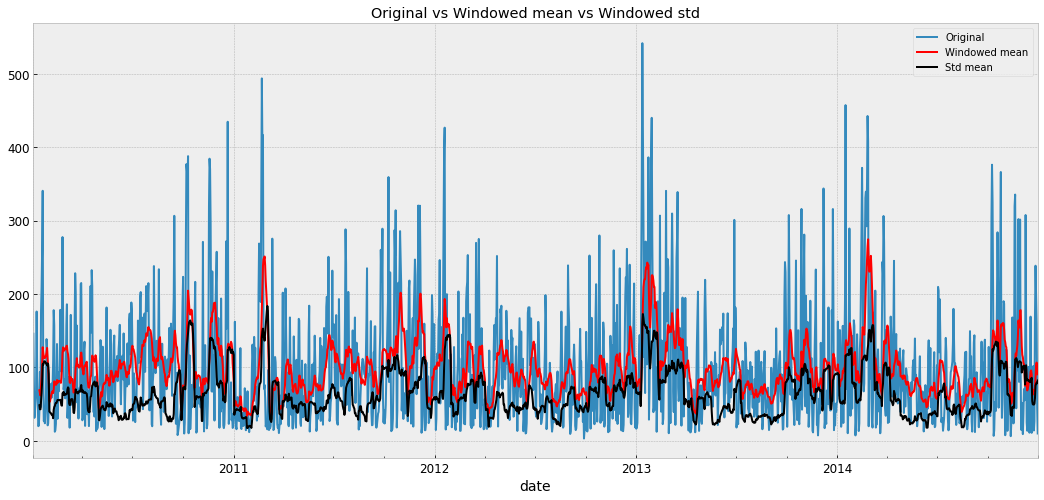

In [33]:
air_pollution.pollution_today.plot(label='Original')
air_pollution.pollution_today.rolling(window=12).mean().plot(
    color='red', label='Windowed mean')
air_pollution.pollution_today.rolling(window=12).std().plot(
    color='black', label='Std mean')
plt.legend()
plt.title('Original vs Windowed mean vs Windowed std')

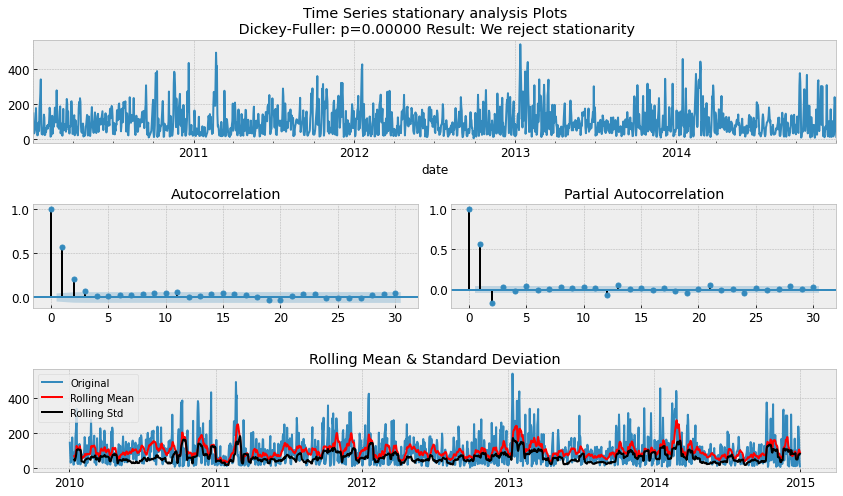

In [41]:
tsplot(air_pollution.pollution_today, lags=30)




```
Difference transform
```



In [30]:
def difference(dataset, interval=1, order=1):
    for u in range(order):
        diff = list()
        for i in range(interval, len(dataset)):
            value = dataset[i] - dataset[i - interval]
            diff.append(value)
        dataset = diff
    return diff

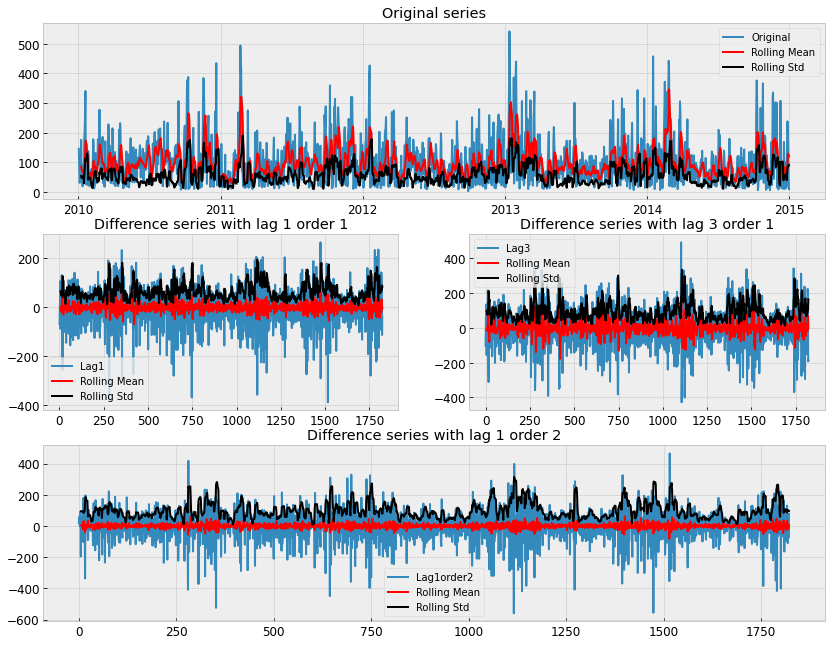

In [32]:
lag1series = pd.Series(difference(air_pollution.pollution_today, interval=1, order=1))
lag3series = pd.Series(difference(air_pollution.pollution_today, interval=3, order=1))
lag1order2series = pd.Series(difference(
    air_pollution.pollution_today, interval=1, order=2))

fig = plt.figure(figsize=(14, 11))
layout = (3, 2)
original = plt.subplot2grid(layout, (0, 0), colspan=2)
lag1 = plt.subplot2grid(layout, (1, 0))
lag3 = plt.subplot2grid(layout, (1, 1))
lag1order2 = plt.subplot2grid(layout, (2, 0), colspan=2)

original.set_title('Original series')
original.plot(air_pollution.pollution_today, label='Original')
original.plot(air_pollution.pollution_today.rolling(
    7).mean(), color='red', label='Rolling Mean')
original.plot(air_pollution.pollution_today.rolling(7).std(),
              color='black', label='Rolling Std')
original.legend(loc='best')

lag1.set_title('Difference series with lag 1 order 1')
lag1.plot(lag1series, label="Lag1")
lag1.plot(lag1series.rolling(7).mean(), color='red', label='Rolling Mean')
lag1.plot(lag1series.rolling(7).std(), color='black', label='Rolling Std')
lag1.legend(loc='best')

lag3.set_title('Difference series with lag 3 order 1')
lag3.plot(lag3series, label="Lag3")
lag3.plot(lag3series.rolling(7).mean(), color='red', label='Rolling Mean')
lag3.plot(lag3series.rolling(7).std(), color='black', label='Rolling Std')
lag3.legend(loc='best')

lag1order2.set_title('Difference series with lag 1 order 2')
lag1order2.plot(lag1order2series, label="Lag1order2")
lag1order2.plot(lag1order2series.rolling(7).mean(),
                color='red', label='Rolling Mean')
lag1order2.plot(lag1order2series.rolling(7).std(),
                color='black', label='Rolling Std')
lag1order2.legend(loc='best')



```
Log scale transformation
```



Text(0.5, 1.0, 'Log scale transformation into original series')

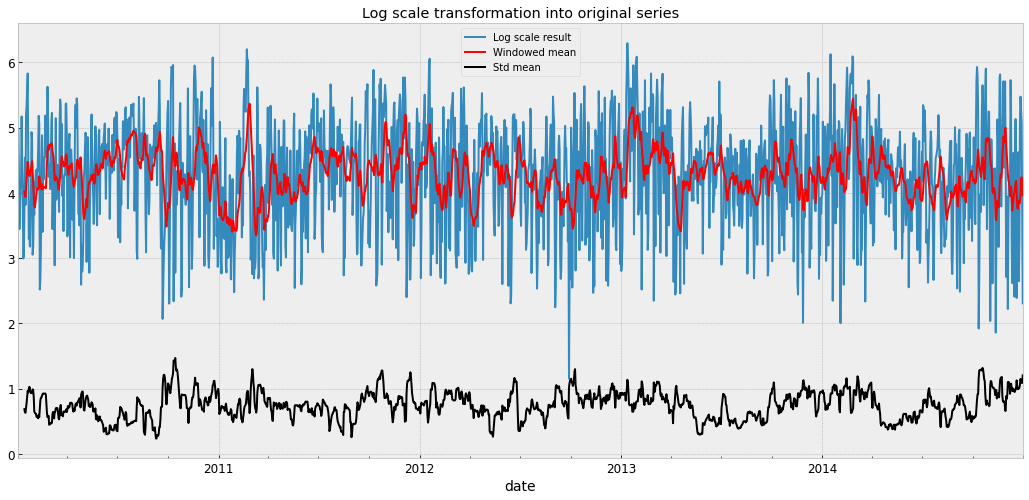

In [36]:
ts_log = np.log(air_pollution.pollution_today)
ts_log.plot(label='Log scale result')
ts_log.rolling(window=12).mean().plot(color='red', label='Windowed mean')
ts_log.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()
plt.title('Log scale transformation into original series')



```
Smoothing
```



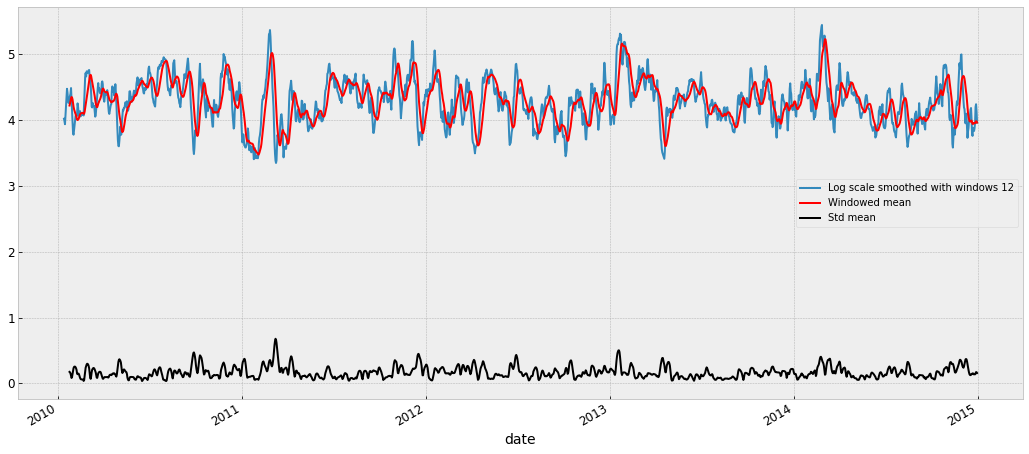

In [38]:
avg = pd.Series(ts_log).rolling(12).mean()
plt.plot(avg, label='Log scale smoothed with windows 12')
avg.rolling(window=12).mean().plot(color='red', label='Windowed mean')
avg.rolling(window=12).std().plot(color='black', label='Std mean')
plt.legend()

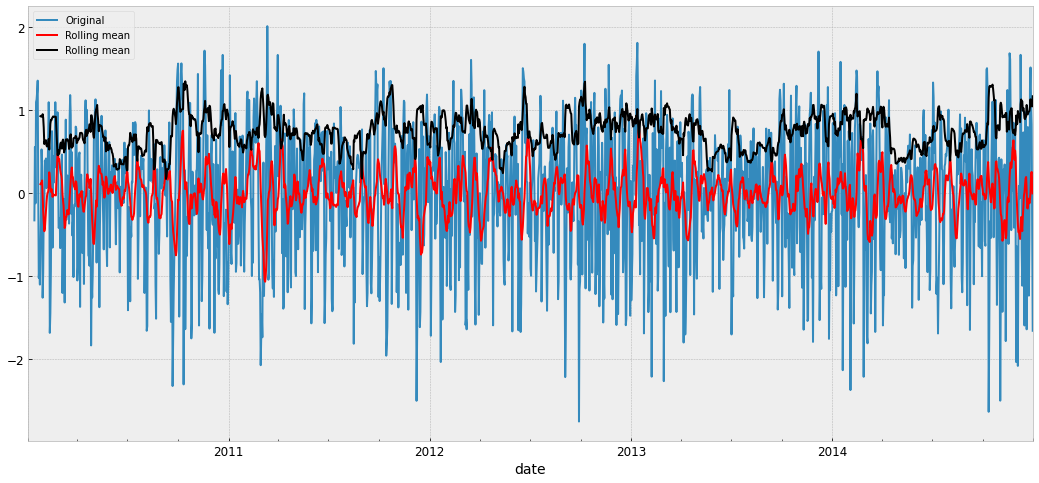

In [39]:
ts_log_moving_avg_diff = ts_log - avg

ts_log_moving_avg_diff.plot(label='Original')
ts_log_moving_avg_diff.rolling(12).mean().plot(
    color='red', label="Rolling mean")
ts_log_moving_avg_diff.rolling(12).std().plot(
    color='black', label="Rolling mean")
plt.legend(loc='best')